# Ptychographic Reconstructions

Ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities in the far-field:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

## Simultaneous Reconstruction of Electrostatic and Magnetic Phase Contributions

In this tutorial, we use two sets of far-field diffraction intensities to jointly reconstruct the electrostatic and out-of-plane magnetic vector potential of a crystalline sample described by the Aharonov-Bohm phase shift:

$$
\begin{aligned}
    \phi(\boldsymbol{r}_\bot) &= \phi_e(\boldsymbol{r}_\bot)+\phi_m(\boldsymbol{r}_\bot) \\
    &= \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz -\frac{e}{\hbar}\int_L\boldsymbol{A}(\boldsymbol{r}_{\bot},z)\cdot d\boldsymbol{r}
\end{aligned}
$$

Since the phases enter the multislice transmission function as follows:

$$
\begin{aligned}
T &= \exp{\left[-i \sigma V(r)\right]} \times \exp{\left[-i A(r)\right]} \\
  &= \exp{\left[-i \sigma \left[ V(r) + A(r)/\sigma \right]\right]}
\end{aligned}
$$

we will 'hijack' the `PotentialArray` object to model a dummy magnetic vector potential.  
_Note:_ we'll need to divide by the interaction parameter $\sigma$, to ensure this works properly.

For the electrostatic potential, we will use the same (thin) slab of [110] STO:

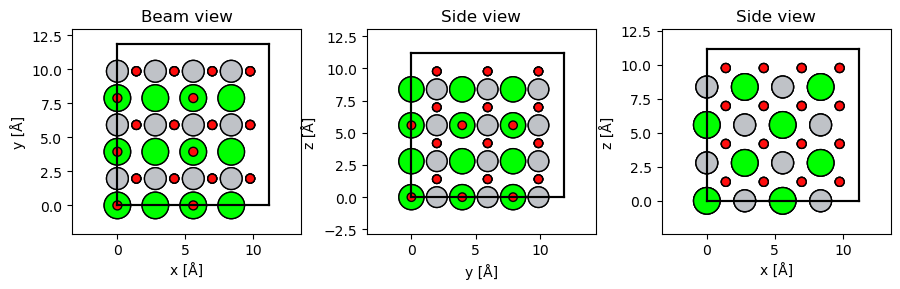

In [8]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

from abtem import FrozenPhonons, Potential
from abtem import CTF, Probe

STO_unit_cell   = read('data/SrTiO3.cif')
STO_atoms       = surface(STO_unit_cell, (1,1,0), 4, periodic=True)*(2,3,1)

frozen_phonons          = FrozenPhonons(STO_atoms, 1024, {'Sr' : .05, 'Ti' : .05, 'O' : .05}, seed=1)
electrostatic_potential = Potential(frozen_phonons,
                                    sampling=0.02,
                                    device='gpu',
                                    projection='infinite',
                                    parametrization='kirkland').build()

ctf             = CTF(parameters={'C10': -75,'C12': 20, 'phi12': 0.785,'C30':-7e4},semiangle_cutoff=24)
probe           = Probe(semiangle_cutoff=24,
                        energy=200e3,
                        ctf=ctf,
                        device='gpu')

probe.match_grid(electrostatic_potential)

from abtem import show_atoms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))

show_atoms(STO_atoms, ax = ax1, title = 'Beam view')
show_atoms(STO_atoms, ax = ax2, plane = 'yz', title = 'Side view')
show_atoms(STO_atoms, ax = ax3, plane = 'xz', title = 'Side view')

fig.tight_layout();

For the dummy magnetic vector potential, we'll use two gaussians with opposite sign and asymmetric amplitudes:

In [5]:
import cupy as cp
import numpy as np
from cupyx.scipy.special import erf
from abtem.measure import Calibration, Measurement

def projected_gaussian_potential(x,y,
                                 z0=10.,z1=0.,
                                 l=10.,w=10.,t=10.,
                                 sigma=1.,asymmetry=2.):
    return (
        asymmetry*(
            cp.exp(-((w-4*y)**2+(l-4*x)**2)/(32*sigma**2))*(
                erf((t-4*z0)/(4*cp.sqrt(2)*sigma))-
                erf((t-4*z1)/(4*cp.sqrt(2)*sigma))
            )
        )+(
            cp.exp(-(9*l**2+9*w**2-24*l*x - 24*w*y+16*(x**2+y**2))/(32*sigma**2))*(
                erf((4*z0-3*t)/(4*cp.sqrt(2)*sigma))-
                erf((4*z1-3*t)/(4*cp.sqrt(2)*sigma))
            )
        )
    )/(4*asymmetry*cp.pi*sigma**2)

def match_grid(potential):
    gx, gy    = potential.gpts
    lx, ly    = potential.extent

    return cp.meshgrid(
        cp.linspace(0.,lx,gx,endpoint=False),
        cp.linspace(0.,ly,gy,endpoint=False),
        indexing='ij'
    )

def get_cumulative_thicknesses(potential):
    return np.flipud(np.cumsum(np.insert(potential.slice_thicknesses,0,0)))

projected_gaussian_calibrations = tuple(Calibration(0., d, 'Å', name, endpoint=False) 
                                        for name, d in zip(('x','y'),electrostatic_potential.sampling))

x,y                             = match_grid(electrostatic_potential)
l,w,t                           = STO_atoms.cell.lengths()
projected_gaussian_measurement  = Measurement(projected_gaussian_potential(x,y,
                                                                           z0=t,z1=0,
                                                                           l=l,w=w,t=t,
                                                                           sigma=1.0,asymmetry=2.
                                                                          ),
                                              projected_gaussian_calibrations)

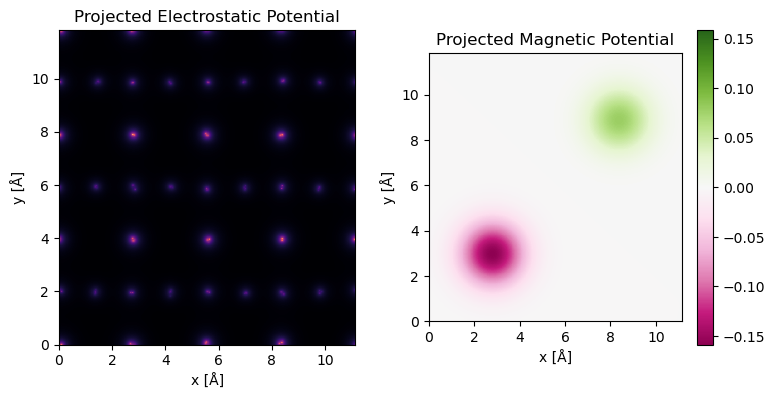

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))

electrostatic_potential.project().show(cmap='magma',figsize=(4,4),title='Projected Electrostatic Potential',ax=ax1)

cmin= np.amin(projected_gaussian_measurement.array)
projected_gaussian_measurement.show(cmap='PiYG',cbar=True,vmin=cmin,vmax=-cmin,figsize=(4,4),
                                    title='Projected Magnetic Potential',ax=ax2)
fig.tight_layout()

In [9]:
from abtem.utils import energy2sigma

cumulative_thicknesses           = get_cumulative_thicknesses(electrostatic_potential)
magnetic_potential               = cp.empty(electrostatic_potential.array.shape)

for slice_id in range(electrostatic_potential.num_slices):
    magnetic_potential[slice_id] = projected_gaussian_potential(x,y,
                                                                z0=cumulative_thicknesses[slice_id],
                                                                z1=cumulative_thicknesses[slice_id+1],
                                                                l=l,w=w,t=t,
                                                                sigma=1.0,asymmetry=2.)

magnetic_potential              /= energy2sigma(probe.energy)

We'll perform two additional 4DSTEM simulations:
1. One with a positive magnetic vector potenial ('measurement_forward')
2. One with a negative magnetic vector potential ('measurement_reverse')

In [11]:
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan

pixelated_detector  = PixelatedDetector(max_angle=120)
gridscan            = GridScan((0,0), electrostatic_potential.extent, sampling = 0.9*probe.ctf.nyquist_sampling)

modified_potential_forward         = electrostatic_potential.copy()
modified_potential_forward._array += magnetic_potential

measurement_forward                = probe.scan(gridscan,
                                                pixelated_detector,
                                                modified_potential_forward)

modified_potential_reverse         = electrostatic_potential.copy()
modified_potential_reverse._array -= magnetic_potential

measurement_reverse                = probe.scan(gridscan,
                                                pixelated_detector,
                                                modified_potential_reverse)

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

In theory, we could do two independent Regularized-PIE reconstructions for `measurement_forward` and `measurement_reverse` and then use the following relationship to separate the electrostatic and magnetic phase contributions:

$$
\begin{aligned}
\phi_e &= \left(\phi^{(\mathrm{forward})} + \phi^{(\mathrm{reverse})}\right)/2 \\
\phi_m &= \left(\phi^{(\mathrm{forward})} - \phi^{(\mathrm{reverse})}\right)/2
\end{aligned}
$$

In [14]:
from abtem.reconstruct import RegularizedPtychographicOperator

forward_measurement_ptycho_operator = RegularizedPtychographicOperator(measurement_forward,
                                                                       semiangle_cutoff=24,
                                                                       energy=200e3,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(0,0)}).preprocess()

forward_objects, forward_probes, forward_positions, forward_sse = forward_measurement_ptycho_operator.reconstruct(max_iterations = 10,
                                                                                                                  verbose=True,
                                                                                                                  random_seed=1,
                                                                                                                  return_iterations=True)

reverse_measurement_ptycho_operator = RegularizedPtychographicOperator(measurement_reverse,
                                                                       semiangle_cutoff=24,
                                                                       energy=200e3,
                                                                       device='gpu',
                                                                       parameters={'object_px_padding':(0,0)}).preprocess()

reverse_objects, reverse_probes, reverse_positions, reverse_sse = reverse_measurement_ptycho_operator.reconstruct(max_iterations = 10,
                                                                                                                  verbose=True,
                                                                                                                  random_seed=1,
                                                                                                                  return_iterations=True)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 23500 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.746e-06
----Iteration 1 , SSE = 1.467e-07
----Iteration 2 , SSE = 7.608e-08
----Iteration 3 , SSE = 7.484e-08
----Iteration 4 , SSE = 7.480e-08
----Iteration 5 , SSE = 7.496e-08
----Iteration 6 , SSE = 7.431e-08
----Iteration 7 , SSE = 7.460e-08
----Iteration 8 , SSE = 7.440e-08
----Iteration 9 , SSE = 7.445e-08
Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 23500 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.714e-06
----Iteration 1 , SSE = 1.407e-07
----Iteration 2 , SSE = 7.552e-08
----Iteration 3 , SSE = 7.417e-08
----Iteration 4 , SSE = 7.474e-08
----Iteration 5 , SSE = 7.479e-08
----Iteration 6 , SSE = 7.407e-08
----Iteration 7 , SSE = 7.436e-08
----Iteration 8 , SSE = 7.431e-08
----Iteration 9 , SSE = 7.436e-08


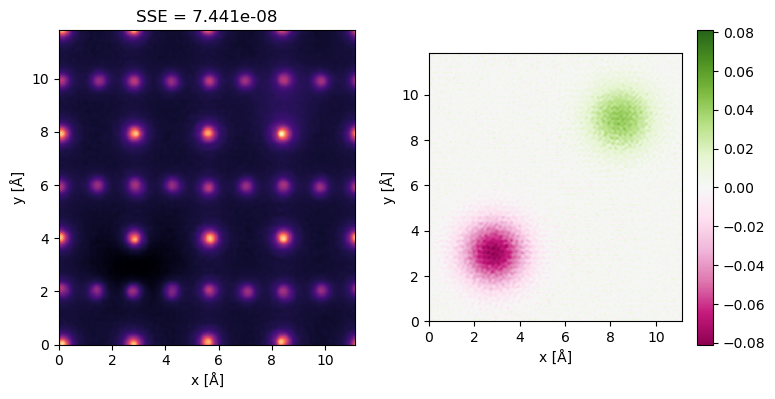

In [15]:
electrostatic_object = (forward_objects[-1].angle()+reverse_objects[-1].angle())/2
magnetic_object      = (forward_objects[-1].angle()-reverse_objects[-1].angle())/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

electrostatic_object.interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                        ax=ax1,
                                                                        title=f"SSE = {float((forward_sse[-1]+reverse_sse[-1])/2):.3e}")

cmin_subtraction = np.amin(magnetic_object.array)

magnetic_object.interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                   cbar=True,
                                                                   vmin=cmin_subtraction,
                                                                   vmax=-cmin_subtraction,
                                                                   ax=ax2)

fig.tight_layout();

This works reasonably well, however since the magnetic vector potential is so much smaller compared to the electrostatic potential - we are amplifying our noise by subtracting our two reconstructions.

Instead, we can use our knowledge of the forward models to modify our exit-wave and update-rule formulations to jointly-reconstruct both objects using two sets of diffraction patterns:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}} &= P^{\psi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M_{\boldsymbol{r}-\boldsymbol{R}_j} \\
\phi_{j \boldsymbol{r}} &= P^{\phi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M^*_{\boldsymbol{r}-\boldsymbol{R}_j}
\end{aligned}
$$

In [16]:
from abtem.reconstruct import SimultaneousPtychographicOperator

simultaneous_reconstruction_ptycho_operator = SimultaneousPtychographicOperator((measurement_forward,measurement_reverse),
                                                                                 semiangle_cutoff=24,
                                                                                 energy=200e3,
                                                                                 device='gpu',
                                                                                 parameters={'object_px_padding':(0,0)}).preprocess()

simpie_objects, simpie_probes, simpie_positions, simpie_sse  = simultaneous_reconstruction_ptycho_operator.reconstruct(
    max_iterations = 10,
    verbose=True,
    random_seed=1,
    return_iterations=True,
    parameters={'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 0 steps
--Simultaneous PIE for 23500 steps
--Probe correction is enabled


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.498e-06
----Iteration 1 , SSE = 3.985e-07
----Iteration 2 , SSE = 1.426e-07
----Iteration 3 , SSE = 5.391e-08
----Iteration 4 , SSE = 5.110e-08
----Iteration 5 , SSE = 5.004e-08
----Iteration 6 , SSE = 4.917e-08
----Iteration 7 , SSE = 4.868e-08
----Iteration 8 , SSE = 4.830e-08
----Iteration 9 , SSE = 4.799e-08


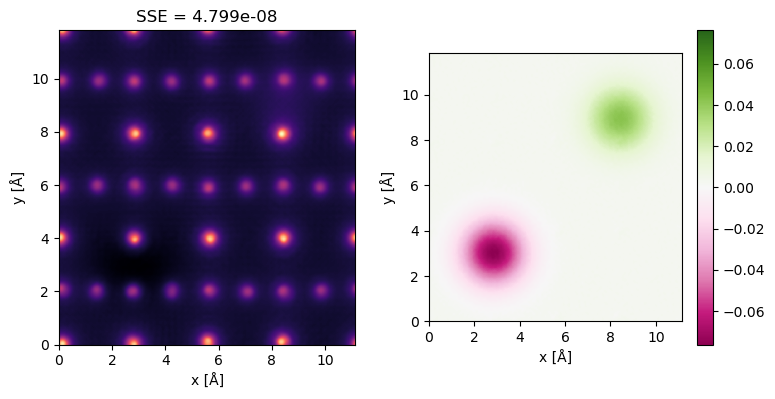

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

simpie_objects[-1][0].angle().interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                                 ax=ax1,
                                                                                 title=f"SSE = {float(simpie_sse[-1]):.3e}")

cmin_simultaneous = np.amin(simpie_objects[-1][1].angle().array)

simpie_objects[-1][1].angle().interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                                 cbar=True,
                                                                                 vmin=cmin_simultaneous,
                                                                                 vmax=-cmin_simultaneous,
                                                                                 ax=ax2)

fig.tight_layout();

This indeed works significantly better, but we can improve its convergence and speed by taking Regularized-PIE `warmup_update_steps`.  
Also, the `common_probe` reconstruction option allows one to use a single probe for both projections (sacrificing some accuracy for speed):

In [18]:
simultaneous_reconstruction_ptycho_operator_02 = SimultaneousPtychographicOperator((measurement_forward,measurement_reverse),
                                                                                    semiangle_cutoff=24,
                                                                                    energy=200e3,
                                                                                    device='gpu',
                                                                                    parameters={'object_px_padding':(0,0)}).preprocess()

simpie_objects_02, simpie_probes_02, simpie_positions_02, simpie_sse_02  = simultaneous_reconstruction_ptycho_operator_02.reconstruct(
    max_iterations = 10,
    verbose=True,
    random_seed=1,
    common_probe = True,
    warmup_update_steps = simultaneous_reconstruction_ptycho_operator_02._num_diffraction_patterns*5,
    return_iterations=True,
    parameters={'step_size_damping_rate':0.75})

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Simultaneous PIE for 11750 steps
--Probe correction is enabled
--Using the first probe as a common probe for both objects


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 1.746e-06
----Iteration 1 , SSE = 1.472e-07
----Iteration 2 , SSE = 6.314e-08
----Iteration 3 , SSE = 5.708e-08
----Iteration 4 , SSE = 5.387e-08
----Iteration 5 , SSE = 5.265e-08
----Iteration 6 , SSE = 5.063e-08
----Iteration 7 , SSE = 4.971e-08
----Iteration 8 , SSE = 4.906e-08
----Iteration 9 , SSE = 4.855e-08


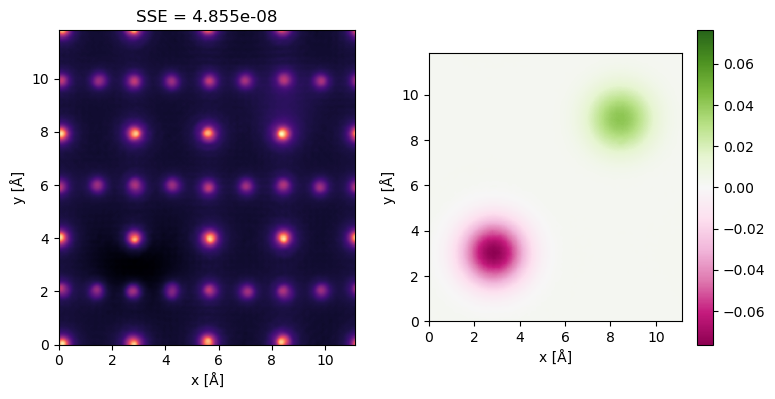

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

simpie_objects_02[-1][0].angle().interpolate(electrostatic_potential.sampling).show(cmap='magma',
                                                                                    ax=ax1,
                                                                                    title=f"SSE = {float(simpie_sse_02[-1]):.3e}")

cmin_common = np.amin(simpie_objects_02[-1][1].angle().array)

simpie_objects_02[-1][1].angle().interpolate(electrostatic_potential.sampling).show(cmap='PiYG',
                                                                                    cbar=True,
                                                                                    vmin=cmin_simultaneous,
                                                                                    vmax=-cmin_simultaneous,
                                                                                    ax=ax2)

fig.tight_layout();